#1-1

MNIST 데이터셋을 사용하여 간단한 GAN을 구현한 코드입니다.

코드를 실행시키고, 주석을 달아주세요.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image


In [2]:
num_epochs = 100
batch_size = 100
learning_rate = 0.0002
img_size = 28 * 28
noise_size = 100
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
dir_name = "GAN_results"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(dir_name):
    os.makedirs(dir_name)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

MNIST_dataset = datasets.MNIST(root='../../data/',
                               train=True,
                               transform=transform,
                               download=True)

data_loader = torch.utils.data.DataLoader(dataset=MNIST_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40481969.40it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1182642.38it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10867447.42it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4003052.90it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, hidden_size3),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)
generator = Generator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)


In [4]:
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_images = images.reshape(batch_size, -1).to(device)

        g_optimizer.zero_grad()

        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        g_loss = criterion(discriminator(fake_images), real_labels)
        g_loss.backward()
        g_optimizer.step()

        d_optimizer.zero_grad()

        z = torch.randn(batch_size, noise_size).to(device)
        fake_images = generator(z)

        real_loss = criterion(discriminator(real_images), real_labels)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        if (i + 1) % 150 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(data_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    save_image(fake_images.view(batch_size, 1, 28, 28),
               os.path.join(dir_name, f'GAN_fake_image_{epoch + 1}.png'))

    d_performance = discriminator(real_images).mean().item()
    g_performance = discriminator(fake_images).mean().item()
    print(f"---------Epoch [{epoch + 1}/{num_epochs}] : D Performance: {d_performance:.2f}, G Performance: {g_performance:.2f}")

Epoch [1/100], Step [150/600], D Loss: 0.0275, G Loss: 3.7262
Epoch [1/100], Step [300/600], D Loss: 0.0085, G Loss: 14.0254
Epoch [1/100], Step [450/600], D Loss: 0.0032, G Loss: 7.2568
Epoch [1/100], Step [600/600], D Loss: 0.0034, G Loss: 8.4078
---------Epoch [1/100] : D Performance: 1.00, G Performance: 0.00
Epoch [2/100], Step [150/600], D Loss: 0.0624, G Loss: 8.9484
Epoch [2/100], Step [300/600], D Loss: 0.0048, G Loss: 9.4584
Epoch [2/100], Step [450/600], D Loss: 0.0156, G Loss: 17.2904
Epoch [2/100], Step [600/600], D Loss: 0.1064, G Loss: 15.5772
---------Epoch [2/100] : D Performance: 0.98, G Performance: 0.01
Epoch [3/100], Step [150/600], D Loss: 0.3701, G Loss: 22.1923
Epoch [3/100], Step [300/600], D Loss: 0.0466, G Loss: 23.7210
Epoch [3/100], Step [450/600], D Loss: 0.1664, G Loss: 14.8227
Epoch [3/100], Step [600/600], D Loss: 0.4536, G Loss: 5.5179
---------Epoch [3/100] : D Performance: 0.77, G Performance: 0.04
Epoch [4/100], Step [150/600], D Loss: 0.3795, G Los

#1-2

아래 마크다운으로 GAN_fake_image_1.png와 GAN_fake_image_100.png를 함께 첨부해주세요.

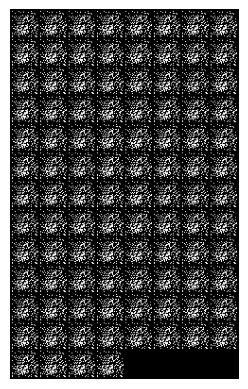

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = '/content/GAN_results/GAN_fake_image_1.png'

img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()

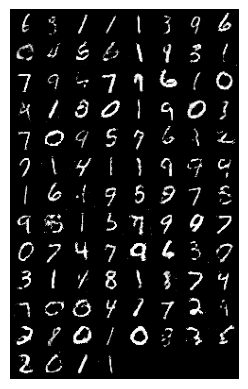

In [7]:
image_path = '/content/GAN_results/GAN_fake_image_100.png'

img = Image.open(image_path)

plt.imshow(img)
plt.axis('off')
plt.show()